In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def Discrete_RW_T(A):    # Calculate the degree vector (sum of non-zero elements in each row)
    degree_vector = np.array(A.sum(axis=1)).ravel()

    # Avoid division by zero by setting degree to 1 for nodes with no edges
    no_out_edges = degree_vector == 0
    degree_vector[no_out_edges] = 1.0

    # Create a diagonal matrix from the inverted degree vector
    degree_matrix = np.diag(1.0 / degree_vector)

    # Calculate the random walk Transition matrix: T = D^(-1) * A
    T = degree_matrix @ A
    np.fill_diagonal(T, no_out_edges, wrap=False)
    return T

In [16]:
def stochastic_branching_tree_adjacency_matrix(distr, d):
    # Start with a list to track nodes at each level
    levels = [[0]]  # Root node is at level 0
    
    # Adjacency list to build the tree dynamically
    adjacency_list = []
    node_index = 1  # Index of the next node to be added

    # Generate the tree level by level up to depth d
    for level in range(d):
        current_level = levels[level]
        next_level = []
        
        # For each node in the current level, sample the number of children
        for parent in current_level:
            num_children = distr()
            children = []

            for _ in range(num_children):
                children.append(node_index)
                adjacency_list.append((parent, node_index))  # Add edge to adjacency list
                node_index += 1

            next_level.extend(children)  # Add children to the next level

        if next_level:
            levels.append(next_level)
        else:
            break  # Stop if no new children were added

    # Convert adjacency list to adjacency matrix
    total_nodes = node_index
    adjacency_matrix = np.zeros((total_nodes, total_nodes), dtype=int)
    
    for parent, child in adjacency_list:
        adjacency_matrix[parent, child] = 1
        adjacency_matrix[child, parent] = 1  # Symmetric for undirected tree

    return adjacency_matrix, levels

In [74]:
# Function to compute and normalize level-wise distributions for first row of T^n
def level_distribution_first_row(T, levels, max_power):
    # Results container for normalized distributions of first row
    distributions = {}

    # Iterate over powers
    for n in range(1, max_power + 1):
        T_n = np.linalg.matrix_power(T, n)
        distributions[n] = []

        # Extract the first row (source node's probabilities to other nodes)
        first_row_entries = T_n[0, :]

        # For each level, gather and normalize entries
        for level in range(len(levels)):
            level_entries = first_row_entries[levels[level]]  # Select entries for current level
            
            # Normalize entries for the current level if there are non-zero entries
            if level_entries.size > 0 and level_entries.sum() > 0:
                distributions[n].append(level_entries)
            else:
                # Append empty list for consistency if there are no valid entries
                distributions[n].append(np.array([]))

    return distributions

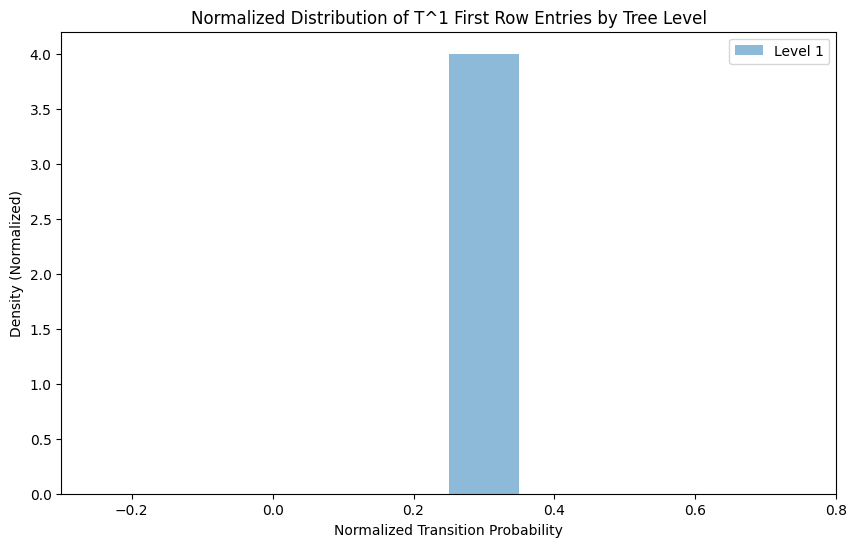

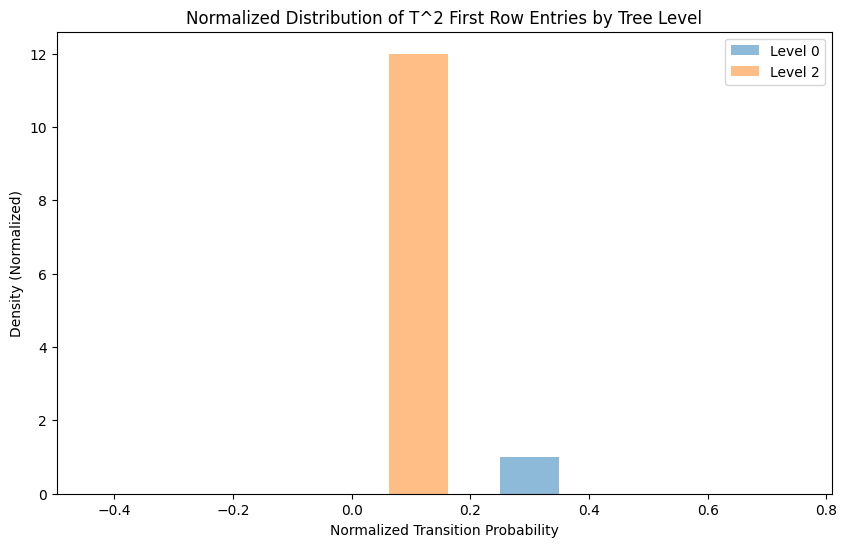

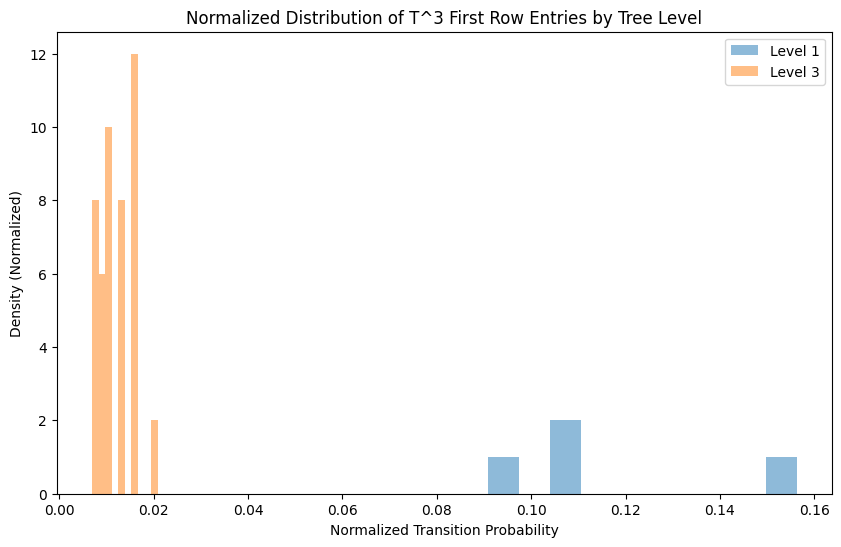

In [75]:
# Define a distribution function, e.g., a Poisson distribution with mean 3
c= 3
distr = lambda: np.random.poisson(c)
A, levels = stochastic_branching_tree_adjacency_matrix(distr=distr, d=3)
T = Discrete_RW_T(A) # Assuming T is computed as described
levels = levels  # levels from your tree generation
distributions = level_distribution_first_row(T, levels, max_power=3)

# Plot the normalized distributions for each power and level
for n, dist_per_level in distributions.items():
    plt.figure(figsize=(10, 6))
    for level, entries in enumerate(dist_per_level):
        if entries.size > 0:  # Only plot non-empty levels
            plt.hist(entries, bins=10, alpha=0.5, label=f'Level {level}', density=False)
    
    plt.title(f"Normalized Distribution of T^{n} First Row Entries by Tree Level")
    plt.xlabel("Normalized Transition Probability")
    plt.ylabel("Density (Normalized)")
    plt.legend()
    plt.show()

## Analysis of the means

In [76]:
def mean_transition_probabilities_first_row(T, levels, max_power):
    # Results container for mean values of first row entries by level
    mean_values = {}

    # Iterate over powers of the transition matrix
    for n in range(1, max_power + 1):
        T_n = np.linalg.matrix_power(T, n)
        mean_values[n] = []

        # Extract the first row (source node's probabilities to other nodes)
        first_row_entries = T_n[0, :]

        # For each level, compute the mean of entries
        for level in range(len(levels)):
            level_entries = first_row_entries[levels[level]]  # Select entries for current level

            # Calculate the mean for the current level if there are non-zero entries
            if level_entries.size > 0:
                mean_values[n].append(np.mean(level_entries))
            else:
                # Append NaN or 0 for consistency if there are no valid entries
                mean_values[n].append(np.nan)

    return mean_values


In [79]:
def sample_mean_transition_probabilities(distr, levels, depth, max_power, num_samples):
    samples = []

    for _ in range(num_samples):
        # Generate a stochastic branching tree adjacency matrix for each instance
        A, levels = stochastic_branching_tree_adjacency_matrix(distr, depth)
        # Generate the transition matrix
        T = Discrete_RW_T(A)
        # Compute mean transition probabilities for this instance
        mean_values = mean_transition_probabilities_first_row(T, levels, max_power)
        samples.append(mean_values)

    return samples

In [117]:
def compute_probabilities(c, d, max_tau):
    # Initialize a 2D array to store probabilities for each level and time step
    probabilities = np.zeros((max_tau + 1, d + 1))
    
    # Set the initial condition: W(0, 0) = 1
    probabilities[0][0] = 1

    # Fill the probabilities table for each time step tau
    for tau in range(1, max_tau + 1):
        for l in range(d + 1):
            # Contribution from level l + 1
            if l + 1 <= d - 1:
                # Apply 1/(c+1) factor for levels other than d-1
                probabilities[tau][l] += probabilities[tau - 1][l + 1] * c / (c + 1)
            elif l + 1 == d:
                # At level d-1, keep the contribution as walks[tau - 1][l + 1] * c
                probabilities[tau][l] += probabilities[tau - 1][l + 1] * c
            
            # Contribution from level l - 1
            if l - 1 > 0:
                # Apply 1/(c+1) factor for levels other than 1
                probabilities[tau][l] += probabilities[tau - 1][l - 1] / (c + 1)
            elif l - 1 == 0:
                # At level 1, use 1/c factor for the root contribution
                probabilities[tau][l] += probabilities[tau - 1][l - 1] / c

    return probabilities

In [141]:
def plot_sampled_means(samples, level, time_step, c, d, max_tau):
    # Extract mean values for the given level and time_step across samples
    sampled_means = [
        sample[time_step][level]
        for sample in samples
        if time_step in sample and level < len(sample[time_step])
    ]

    # Filter out any NaN values in case some samples did not have values for this level
    sampled_means = [mean for mean in sampled_means if not np.isnan(mean)]

    # Compute reference probabilities
    reference_probabilities = compute_probabilities(c, d, max_tau)
    reference_value = reference_probabilities[time_step][level]

    # Compute the mean of the sampled means
    sampled_mean_value = np.mean(sampled_means)

    # Plot using seaborn for a distribution view
    plt.figure(figsize=(8, 5))
    sns.histplot(sampled_means, kde=True, bins=15, color="blue", label="Sampled Means")
    
    # Add the red vertical line for the reference probability
    plt.axvline(reference_value, color='red', linestyle='--', linewidth=2, label=f'Reference (Level {level}, Time {time_step})')
    
    # Add the blue vertical line for the mean of the sampled distribution
    plt.axvline(sampled_mean_value, color='blue', linestyle='--', linewidth=2, label='Mean of Sampled Means')

    plt.title(f"Sampled Mean Transition Probabilities for Level {level} at Time Step T^{time_step}")
    plt.xlabel("Mean Transition Probability")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [158]:
samples = sample_mean_transition_probabilities(distr, levels, depth=7, max_power=10, num_samples=10)


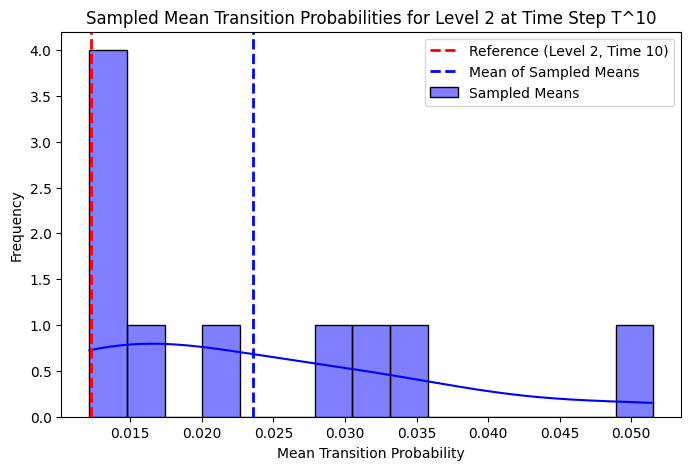

In [168]:
plot_sampled_means(samples, level=2, time_step=10, c=3, d=7, max_tau=10)